## Burning Area Monitoring

The wildfire that swept through Athens and Mati in the summer of 2018 left a profound impact on both the environment and local communities. In response to such disasters, satellite imagery has proven invaluable for assessing and monitoring the extent of fire damage. One crucial tool in this assessment is the differenced Normalized Burn Ratio (dNBR), derived from Sentinel-2 satellite data. dNBR compares pre- and post-fire conditions by subtracting the pre-fire NBR from the post-fire NBR, highlighting areas of significant burn severity where vegetation and surface conditions have been altered.

The application of dNBR allows for detailed mapping of burn severity, providing insights into the intensity of fire impacts across the affected landscape. By leveraging Sentinel-2's high spatial resolution and multispectral capabilities, analysts can identify and prioritize areas for intervention and rehabilitation efforts. This notebook explores how dNBR analysis was utilized to assess the Athens-Mati fire of 2018, showcasing its utility in environmental monitoring, disaster response, and land management strategies.

### The NBR index

NBR stands for Normalized Burn Ratio. It is a spectral index commonly used in remote sensing and satellite imagery analysis, particularly for assessing fire damage and burn severity in natural landscapes. The NBR index is calculated using near-infrared (NIR) and shortwave infrared (SWIR) bands of satellite imagery.

The formula for NBR is:

$$
\begin{aligned}
\text{NBR} & = \frac{(\text{NIR} - \text{SWIR})}{(\text{NIR} + \text{SWIR})} \\
\end{aligned}
$$

The NBR index is particularly useful for assessing the severity of burn scars and fire-affected areas in vegetation. It works on the principle that burned areas exhibit different reflectance properties in NIR and SWIR bands compared to unburned or healthy vegetation:

<b>Positive Values:</b> Typically represent healthy vegetation.

<b>Negative Values:</b> Indicate areas affected by fire, with more negative values indicating greater burn severity.

### Load Required Libraries

In [1]:
import pyproj
import pystac_client

from shapely.geometry import box
from shapely.ops import transform

import odc.stac
from odc.geo.geobox import GeoBox
import matplotlib.colors as mcolors

from geogif import dgif
#from dea_tools.plotting import rgb

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
def calculate_index(data, index):

    """
    Optical Indices Computation

    :param xarray: datacube_object
    :param string: you want to compute
    
    """
    if index.lower() == 'cri2':
        B02 = data.B02.astype('float16')
        B05 = data.B05.astype('float16')
        return (1/B02)-(1/B05)
    if index.lower() == 'ndvi':
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return (B08-B04)/(B08+B04)
    if index.lower() == 'ndwi':
        B08 = data.B08.astype('float16')
        B03 = data.B03.astype('float16')
        return (B03-B08)/(B08+B03)
    if index.lower() == 'ndmi':
        B08 = data.B08.astype('float16')
        B11 = data.B11.astype('float16')
        return (B08-B11)/(B08+B11)
    if index.lower() == 'psri':
        B02 = data.B02.astype('float16')
        B04 = data.B04.astype('float16')
        B06 = data.B06.astype('float16')
        return (B04-B02)/ B06
    if index.lower() == 'savi':
        L = 0.428
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return ((B08 - B04)/(B08 + B04 + L))*(1.0 + L)
    if index.lower() == 'evi':
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return 2.5*(B08-B04)/((B08+6*B04-7.5*B02) + 1.0)
    if index.lower() == 'nbr':
        B12 = data.B12.astype('float16')
        B08 = data.B08.astype('float16')
        return (B08-B12)/(B08+B12)
    if index.lower() == 'visual':
        B02 = data.B02.astype('float16')
        B03 = data.B03.astype('float16')
        B04 = data.B04.astype('float16')
        return B02 + B03 + B04
    if index.lower() == 'bi':
        B02 = data.B02.astype('float16')
        B04 = data.B04.astype('float16')
        B08 = data.B08.astype('float16')
        B11 = data.B11.astype('float16')
        return ((B11+B04) - (B08+B02)) / ((B11+B04) + (B08+B02))

In [3]:
def digitize_date(month,day):    
    if month<10:
        month=f"0{month}"

    if day<10:
        day=f"0{day}"

    return month,day

STAC_URL = "https://earth-search.aws.element84.com/v1"
# STAC connection information for Sentinel 2 COGs
# v0 collection
# STAC_COLLECTION = "sentinel-s2-l2a-cogs"
# v1 collection 
STAC_COLLECTION = "sentinel-2-l2a"


# spatial projection information
CRS_STRING = "9705"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg()


# CHANGE THIS!!!
aoi = (24.02,41.21,24.19,41.33) 
aoi_box = box(*aoi)


# CHANGE THIS!!!
START_DATE = "2024-07-08" # BEFORE THE FIRE 15 DAYS
END_DATE = "2024-08-05"   # DATE OF END OF FIRE + 15 DAYS

# STAC items store bounding box info in epsg:4326
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
bbox_4326 = transform(transformer_4326.transform, aoi_box).bounds

catalog = pystac_client.Client.open(STAC_URL)
catalog.add_conforms_to("ITEM_SEARCH")
catalog.add_conforms_to("QUERY")

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=bbox_4326,
    datetime=[START_DATE, END_DATE],
    query={"eo:cloud_cover": {"lt": 50}}
)

stac_items

In [36]:
# dx = 3/3600  # ~90m resolution
dx = 10 / 111320 # ~10m res
epsg = 4326
geobox = GeoBox.from_bbox(aoi, crs=f"epsg:{epsg}", resolution=dx)

# using Open Data Cube stac component
data = odc.stac.load(
    stac_items.items(),
    chunks={},
    geobox=geobox,
    bands=['nir','swir16','green','blue','red','scl'],
    groupby="solar_day" # delete duplicates due to satellite overlap
)

data2 = odc.stac.load(
    stac_items.items(),
    chunks={},
    geobox=geobox,
    bands=['swir22', 'nir08', 'red'],
    groupby="solar_day"  # delete duplicates due to satellite overlap
)

In [5]:
data

<xarray.Dataset> Size: 334MB
Dimensions:      (latitude: 1337, longitude: 1894, time: 12)
Coordinates:
  * latitude     (latitude) float64 11kB 41.33 41.33 41.33 ... 41.21 41.21 41.21
  * longitude    (longitude) float64 15kB 24.02 24.02 24.02 ... 24.19 24.19
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 96B 2024-07-08T09:19:10.701000 ... 202...
Data variables:
    nir          (time, latitude, longitude) uint16 61MB dask.array<chunksize=(1, 1337, 1894), meta=np.ndarray>
    swir16       (time, latitude, longitude) uint16 61MB dask.array<chunksize=(1, 1337, 1894), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 61MB dask.array<chunksize=(1, 1337, 1894), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 61MB dask.array<chunksize=(1, 1337, 1894), meta=np.ndarray>
    red          (time, latitude, longitude) uint16 61MB dask.array<chunksize=(1, 1337, 1894), meta=np.ndarray>
    scl          (time, latitude, longitude) uint8 30MB dask.array<chunksize=(1, 1337, 1894), meta=np.ndarray>

In [6]:
# Define SCL values for water and clouds
water_classes = [6]  # Water
cloud_classes = [8, 9, 10]  # Cloud shadow, medium probability clouds, high probability clouds, cirrus

# Extract the SCL band
scl = data['scl']

# Create a mask for water and clouds
mask = np.isin(scl, water_classes + cloud_classes)

data = data.where(~mask,np.nan)

# # Apply the mask to each band in the dataset, setting masked areas to NaN
# for band in data.data_vars:
#     data[band] = data[band].where(~mask, np.nan)

c:\Users\nikos\anaconda3\envs\praktiki_new\lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [7]:
B12 = data.swir16.astype('float16')
B08 = data.nir.astype('float16')
B04 = data.red.astype('float16')
data['nbr'] = (B08-B12)/(B08+B12)
data['ndvi'] = (B08-B04)/(B08+B04)

In [8]:
data.time.values

array(['2024-07-08T09:19:10.701000000', '2024-07-11T09:29:06.082000000',
       '2024-07-13T09:19:09.652000000', '2024-07-16T09:29:06.305000000',
       '2024-07-18T09:19:07.821000000', '2024-07-21T09:29:04.637000000',
       '2024-07-23T09:19:10.568000000', '2024-07-26T09:29:05.793000000',
       '2024-07-28T09:19:09.947000000', '2024-07-31T09:29:05.794000000',
       '2024-08-02T09:19:08.014000000', '2024-08-05T09:29:05.581000000'],
      dtype='datetime64[ns]')

In [ ]:
data.nbr.plot(col='time', cmap="Greys_r", col_wrap=4) # na ala3w color map

In [10]:
#pre_fire = data.isel(time=slice(0,images_before_the_fire))
#post_fire = data.isel(time=slice(images_before_the_fire,len(data.time.values)))

In [10]:
images_before_the_fire = 4
#pre_fire = data.isel(time=slice(0, images_before_the_fire))
post_fire = data.isel(time=[-4])  # Επιλέγει μόνο το τελευταίο στοιχείο
pre_fire = data.isel(time=[3])  # Επιλέγει μόνο το τελευταίο στοιχείο


pre_fire_median = pre_fire.median(dim='time')
post_fire_median = post_fire.median(dim='time')


In [12]:
pre_fire_median = pre_fire.median(dim='time')
post_fire_median = post_fire.median(dim='time')

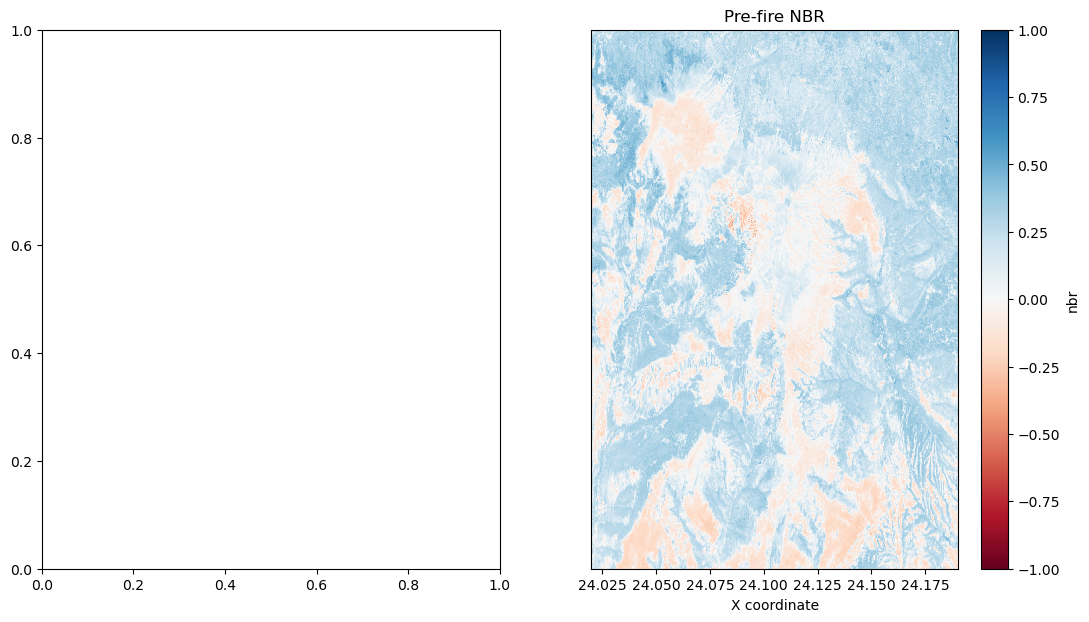

In [14]:
# Υποθέτουμε ότι pre_fire_median είναι ένα xarray.Dataset

# Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

#rgb(pre_fire_median,
    #bands=['red', 'green', 'blue'],
    #ax=ax1)

# Visualise pre-fire image as true colour image
#pre_fire_rgb = np.stack([pre_fire_median['red'].values,
#                         pre_fire_median['green'].values,
#                         pre_fire_median['blue'].values], axis=-1)

#ax1.imshow(pre_fire_rgb)
#ax1.set_title('Pre-fire RGB')
#ax1.set_xlabel('X coordinate')
#ax1.set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
pre_fire_median.nbr.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Pre-fire NBR')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

plt.show()


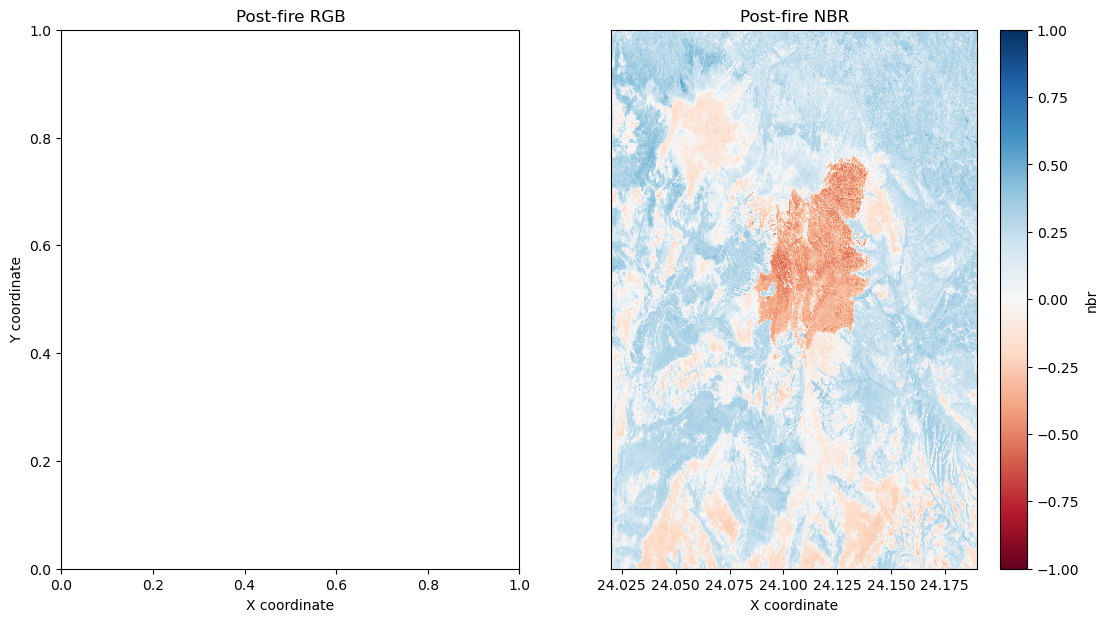

In [15]:
# Set up subplots
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Visualise post-fire image as true colour image
#rgb(post_fire_median,
    #bands=['red', 'green', 'blue'],
    #ax=ax1)


# Visualise pre-fire image as true colour image
post_fire_rgb = np.stack([post_fire_median['red'].values,
                          post_fire_median['green'].values,
                          post_fire_median['blue'].values], axis=-1)

ax1.set_title('Post-fire RGB')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
post_fire_median.nbr.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Post-fire NBR')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

plt.show()

In [11]:
dNBR = pre_fire_median.nbr - post_fire_median.nbr
dNDVI = pre_fire_median.ndvi - post_fire_median.ndvi

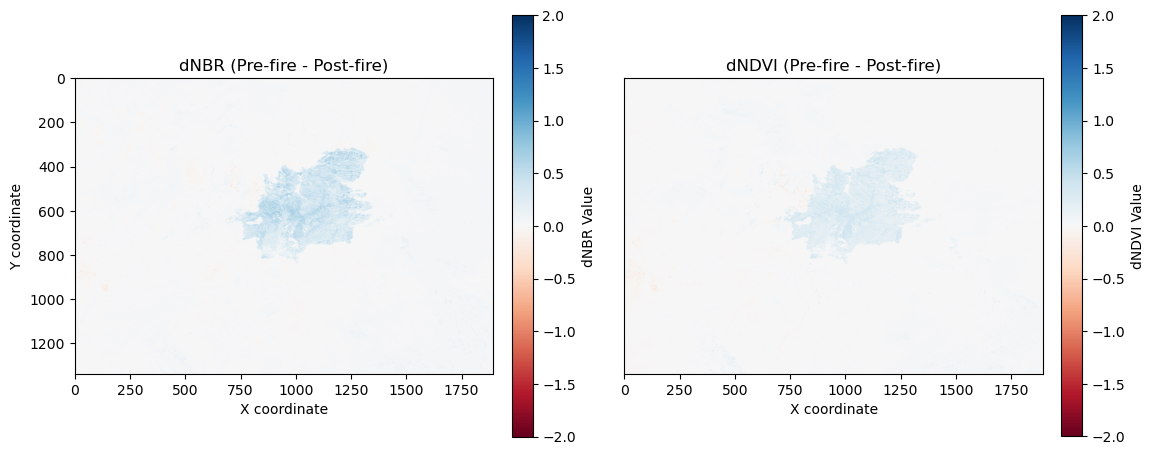

In [17]:
# Υποθέτουμε ότι pre_fire_median και post_fire_median είναι xarray.DataArray ή xarray.Dataset και έχουν ήδη τις τιμές nbr και ndvi υπολογισμένες

# Υπολογισμός των διαφορών
dNBR = pre_fire_median.nbr - post_fire_median.nbr
dNDVI = pre_fire_median.ndvi - post_fire_median.ndvi

# Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Visualise dNBR
im1 = ax1.imshow(dNBR, cmap='RdBu', vmin=-2, vmax=2)
ax1.set_title('dNBR (Pre-fire - Post-fire)')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('dNBR Value')

# Visualise dNDVI
im2 = ax2.imshow(dNDVI, cmap='RdBu', vmin=-2, vmax=2)
ax2.set_title('dNDVI (Pre-fire - Post-fire)')
ax2.set_xlabel('X coordinate')
ax2.yaxis.set_visible(False)
cbar2 = plt.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('dNDVI Value')

plt.show()


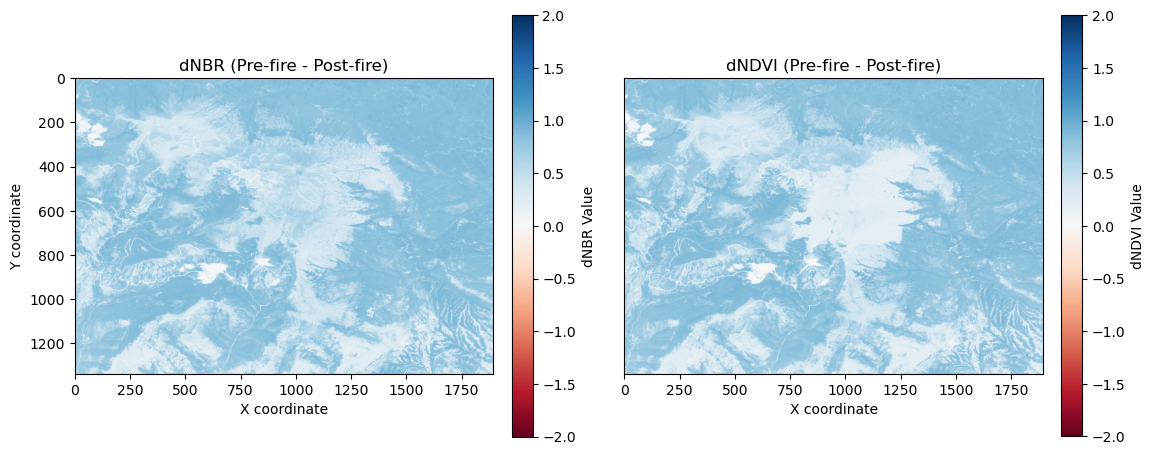

In [107]:
# Υποθέτουμε ότι pre_fire_median και post_fire_median είναι xarray.DataArray ή xarray.Dataset και έχουν ήδη τις τιμές nbr και ndvi υπολογισμένες

# Υπολογισμός των διαφορών
dNBR = pre_fire_median.nbr - post_fire_median.nbr
dNDVI = pre_fire_median.ndvi - post_fire_median.ndvi

# Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Visualise dNBR
im1 = ax1.imshow(pre_fire_median.ndvi, cmap='RdBu', vmin=-2, vmax=2)
ax1.set_title('dNBR (Pre-fire - Post-fire)')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('dNBR Value')

# Visualise dNDVI
im2 = ax2.imshow(post_fire_median.ndvi, cmap='RdBu', vmin=-2, vmax=2)
ax2.set_title('dNDVI (Pre-fire - Post-fire)')
ax2.set_xlabel('X coordinate')
ax2.yaxis.set_visible(False)
cbar2 = plt.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('dNDVI Value')

In [ ]:
# Υποθέτουμε ότι dNBR και dNDVI είναι xarray.DataArray

# Set up subplots for the images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Visualise dNBR
im1 = ax1.imshow(dNBR, cmap='RdBu', vmin=-2, vmax=2)
ax1.set_title('dNBR (Pre-fire - Post-fire)')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('dNBR Value')

# Visualise dNDVI
im2 = ax2.imshow(dNDVI, cmap='RdBu', vmin=-2, vmax=2)
ax2.set_title('dNDVI (Pre-fire - Post-fire)')
ax2.set_xlabel('X coordinate')
ax2.yaxis.set_visible(False)
cbar2 = plt.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('dNDVI Value')

plt.show()

# Set up subplots for the histograms
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Plot histogram of dNBR
ax3.hist(dNBR.values.flatten(), bins=50, color='blue', edgecolor='black')
ax3.set_title('Histogram of dNBR')
ax3.set_xlabel('dNBR Value')
ax3.set_ylabel('Frequency')

# Plot histogram of dNDVI
ax4.hist(dNDVI.values.flatten(), bins=50, color='green', edgecolor='black')
ax4.set_title('Histogram of dNDVI')
ax4.set_xlabel('dNDVI Value')
ax4.set_ylabel('Frequency')

plt.show()


In [ ]:
dNBR.values

In [ ]:
dNDVI

In [ ]:
dNDVI.plot.imshow(cmap='YlGn')

In [ ]:
dNBR.plot.imshow(cmap='RdBu')

In [ ]:
dNDVI.plot.imshow(cmap='YlGn')

In [ ]:
dNBR.plot.imshow(cmap='RdBu')

In [ ]:
dNBR.plot.imshow()

In [42]:
def rgb_composite(data, time):
    def brighten(band):
        alpha = 0.13
        beta = 0
        return np.clip(alpha * band + beta, 0, 255)

    def normalize(band):
        band_min, band_max = band.min(), band.max()
        return (band - band_min) / (band_max - band_min)
    
    # Access the bands using correct variable names
    #red = data['red'].isel(time=time).values
    #green = data['green'].isel(time=time).values
    #blue = data['blue'].isel(time=time).values

    # Access the bands using correct variable names
    red = data['swir22'].isel(time=time).values
    green = data['nir08'].isel(time=time).values
    blue = data['red'].isel(time=time).values

    # Apply brighten and normalize functions
    red_b = brighten(red) # 12
    green_b = brighten(green) # 8A
    blue_b = brighten(blue) # 4

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    # Combine the bands into an RGB composite
    rgb_composite_bn = np.dstack((red_bn, green_bn, blue_bn))

    # Display the RGB composite
    plt.imshow(rgb_composite_bn)
    plt.savefig('swir_nir_red_07_16_2024.png')
    plt.show()
    #plt.savefig('rgb_07_28_2024.png')

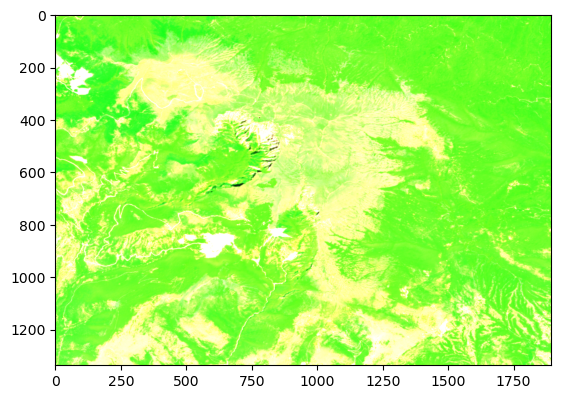

In [43]:
rgb_composite(data2, 3) # -4

In [ ]:
#from datacube.utils.cog import write_cog

#rgb_tiff = data.isel(time=4).to_array()

# Write multi-band GeoTIFF to a location
#write_cog(rgb_tiff,  fname='rgb4.tif', overwrite=True)

In [24]:
import rasterio
from rasterio.transform import from_origin

def save_as_tiff(data_array, file_path):
    # Convert the data type to float32
    data_array = data_array.astype('float32')

    # Get the dimensions and resolution
    channels, height, width = data_array.shape
    print(height, width, channels)
    
    transform = from_origin(data_array.longitude.min(), data_array.latitude.max(), 
                            (data_array.longitude.max() - data_array.longitude.min()) / width,
                            (data_array.latitude.max() - data_array.latitude.min()) / height)

    # Save as a TIFF file
    with rasterio.open(
        file_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=3, # 3 channels R,G,B
        dtype=data_array.dtype,
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(data_array[4, :, :], 1) # green 2, blue 3, red 4 from data array
        dst.write(data_array[2, :, :], 2) 
        dst.write(data_array[3, :, :], 3) 



# Call the function with your data and desired file path
rgb_tiff = data.isel(time=-4).to_array()
file_path = './rgb_2024_07_28.tiff'
save_as_tiff(rgb_tiff, file_path)

1337 1894 8


In [115]:
import rasterio
from rasterio.transform import from_origin

def save_as_tiff(data_array, file_path):
    # Convert the data type to float32
    data_array = data_array.astype('float32')

    # Get the dimensions and resolution
    height, width = data_array.shape
    transform = from_origin(data_array.longitude.min(), data_array.latitude.max(), 
                            (data_array.longitude.max() - data_array.longitude.min()) / width,
                            (data_array.latitude.max() - data_array.latitude.min()) / height)

    # Save as a TIFF file
    with rasterio.open(
        file_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=data_array.dtype,
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(data_array.values, 1)

# Call the function with your data and desired file path
file_path = 'post_fire_ndvi.tiff'
save_as_tiff(post_fire_median.ndvi, file_path)

In [83]:
nbr_masked = xr.where(data.nbr < -0.25, data.nbr, np.nan)
cmap = plt.get_cmap('Reds', 1)

gif_bytes = dgif(arr=nbr_masked, cmap=cmap, bytes=True, fps=2).compute()
with open("nbr.gif", "wb") as f:
    f.write(gif_bytes)


#dgif(arr=data.nbr, cmap=cmap, fps=2).compute() # na to apothikeyei se gif RdYlGn

In [80]:
gif_bytes = dgif(data.nbr, cmap="RdYlGn", bytes=True, fps=1).compute()
with open("nbr.gif", "wb") as f:
    f.write(gif_bytes)

TypeError: a bytes-like object is required, not 'Image'

In [104]:
dNBR_thresholds = {
    'low':         (0.1, 0.27),          # Example thresholds for low severity          # 255, 245, 133  #fff5850 #0.2699
    'medium-low':  (0.27, 0.44),   # Example thresholds for medium-low severity  # 252, 147, 41   #fc9329  #0.4339
    'medium-high': (0.44, 0.66),  # Example thresholds for medium-high severity  # 234, 55, 42   #ea372a #0.659
    'high':        (0.66, 0.9)          # Example thresholds for high severity       # 93, 42, 44    #5d2a2c
}

# Define thresholds for burned classification based on dNDVI, dNBR
dNDVI_burned_threshold = 0.08 
dNBR_burned_threshold = 0.1

# Initial classification: burned vs. not burned based on dNDVI
burned_mask = (dNDVI > dNDVI_burned_threshold) & (dNBR > dNBR_burned_threshold)
#burned_mask = dNBR > dNBR_burned_threshold


# Apply the burned mask to dNBR
dNBR_burned = dNBR.where(burned_mask)

# Initialize the classification array
classification = xr.full_like(dNBR_burned, np.nan, dtype=np.float32)


# Apply the classification based on dNBR thresholds
for category, (low_threshold, high_threshold) in dNBR_thresholds.items():
    category_mask = ((dNBR_burned > low_threshold) & (dNBR_burned <= high_threshold))
    classification = xr.where(category_mask, 
                              {'low': 1, 'medium-low': 2, 'medium-high': 3, 'high': 4}[category], 
                              classification)

# Optionally, set areas where dNBR is not valid or not burned to NaN
classification = xr.where(~burned_mask, np.nan, classification)

In [ ]:
classification.plot.imshow(cmap='YlOrRd')

In [106]:
import rasterio
from rasterio.transform import from_origin

def save_as_tiff(data_array, file_path):
    # Convert the data type to float32
    data_array = data_array.astype('float32')

    # Get the dimensions and resolution
    height, width = data_array.shape
    transform = from_origin(data_array.longitude.min(), data_array.latitude.max(), 
                            (data_array.longitude.max() - data_array.longitude.min()) / width,
                            (data_array.latitude.max() - data_array.latitude.min()) / height)


    red = np.zeros((height, width), dtype=np.uint8)
    green = np.zeros((height, width), dtype=np.uint8)
    blue = np.zeros((height, width), dtype=np.uint8)
  
# Assign colors based on pixel values using xr.where
    red = xr.where(data_array == 1, 255, 
                   xr.where(data_array == 2, 252, 
                            xr.where(data_array == 3, 234, 
                                     xr.where(data_array == 4, 93, 0)))).astype(np.uint8)

    green = xr.where(data_array == 1, 245, 
                     xr.where(data_array == 2, 147, 
                              xr.where(data_array == 3, 55, 
                                       xr.where(data_array == 4, 42, 0)))).astype(np.uint8)

    blue = xr.where(data_array == 1, 133, 
                    xr.where(data_array == 2, 41, 
                             xr.where(data_array == 3, 42, 
                                      xr.where(data_array == 4, 44, 0)))).astype(np.uint8)


    # export masked raster 
    import geopandas as gp
    from rasterio.mask import mask

    mask_df = gp.read_file('./falakro/polygon.shp')
    mask_df = mask_df.to_crs('EPSG:4326')


    # Save as a TIFF file with 3 bands for R, G, B
    with rasterio.open(
        file_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=3,
        dtype=np.uint8,
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(red.values, 1)    # Write the red channel
        dst.write(green.values, 2)  # Write the green channel
        dst.write(blue.values, 3)   # Write the blue channel
    
    with rasterio.open(file_path) as src:
        out_image, out_transform = mask(src, mask_df.geometry, crop=True, all_touched=True, nodata=0)

        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": 0
        })
        cropped_file_path = file_path.replace('.tiff', '_cropped.tiff')
        with rasterio.open(cropped_file_path, "w", **out_meta) as dest:
            dest.write(out_image)
  
    # extract by mask gdal


# Call the function with your data and desired file path
file_path = 'classification_tel.tiff'
save_as_tiff(classification, file_path)

In [ ]:
import numpy as np
import xarray as xr

# Define thresholds for burn severity classification based on dNBR
dNBR_thresholds = {
    'unburned':(),
    'low': (0.1, 0.27),
    'moderate': (0.27, 0.44),
    'high': (0.44, 0.66),
    'very high': (0.66, np.inf)
}

# Define thresholds for burned classification based on dNDVI, dNBR
dNDVI_burned_threshold = 0.1
dNBR_burned_threshold = 0.1

# Initial classification: burned vs. not burned based on dNDVI and dNBR
burned_mask = (dNDVI > dNDVI_burned_threshold) & (dNBR > dNBR_burned_threshold)

# Apply the burned mask to dNBR
dNBR_burned = dNBR.where(burned_mask)

# Initialize the classification array
classification = xr.full_like(dNBR_burned, np.nan, dtype=np.float32)

# Apply the classification based on dNBR thresholds
for category, (low_threshold, high_threshold) in dNBR_thresholds.items():
    category_mask = (dNBR_burned > low_threshold) & (dNBR_burned <= high_threshold)
    classification = xr.where(category_mask, 
                              {'low': 1, 'moderate': 2, 'high': 3, 'very high': 4}[category], 
                              classification)

# Optionally, set areas where dNBR is not valid or not burned to NaN
classification = xr.where(~burned_mask, np.nan, classification)

# Adding the 'unburned' category
unburned_mask = dNBR <= 0.1
classification = xr.where(unburned_mask, 0, classification)

# Print classification for verification
print(classification)


In [ ]:
classification.plot.imshow(cmap='YlOrRd')

In [ ]:
burned_mask

In [ ]:
classification

In [ ]:
classification.plot.imshow(cmap='YlOrRd')

In [ ]:
import rasterio
from rasterio.transform import from_origin

def save_as_tiff(data_array, file_path):
    # Convert the data type to float32
    data_array = data_array.astype('float32')

    # Get the dimensions and resolution
    height, width = data_array.shape
    transform = from_origin(data_array.longitude.min(), data_array.latitude.max(), 
                            (data_array.longitude.max() - data_array.longitude.min()) / width,
                            (data_array.latitude.max() - data_array.latitude.min()) / height)

    # Save as a TIFF file
    with rasterio.open(
        file_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=data_array.dtype,
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(data_array.values, 1)

# Call the function with your data and desired file path
file_path = r'C:\Users\valentina\Desktop\Noa\EMS2\classification.tiff'
save_as_tiff(classification, file_path)

In [ ]:
values, counts = np.unique(classification.values, return_counts=True)

In [ ]:
values

In [ ]:
counts

In [ ]:
counts*100

In [ ]:
dNBR_burned.values

In [ ]:
np.count_nonzero(dNBR_burned.values > 0)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the classification data
cbar = ax.imshow(classification)
plt.title('Burn Severity Classification')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Add a colorbar with labels
cbar = plt.colorbar(cbar, ticks=[1, 2, 3, 4], orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium-Low', 'Medium-High', 'High'])

# Optionally, adjust plot settings
plt.grid(False)
plt.show()

In [ ]:
import numpy as np
import xarray as xr

# Assuming you have the counts array
counts = np.array([48316, 80949, 60050, 2292, 2340671], dtype=np.int64)

# Access latitude and longitude coordinates from the DataArray
latitudes = classification.coords['latitude']
longitudes = classification.coords['longitude']

# Define pixel size (ensure positive difference for pixel size calculation)
pixel_size_deg_lat = abs(latitudes[1] - latitudes[0]).item()
pixel_size_deg_lon = abs(longitudes[1] - longitudes[0]).item()

# Convert degrees to meters (approximately, considering latitude at the equator)
pixel_size_m_lat = pixel_size_deg_lat * 111320
pixel_size_m_lon = pixel_size_deg_lon * 111320

# Calculate the area of each pixel in square meters
pixel_area = pixel_size_m_lat * pixel_size_m_lon

# Category labels
categories = ['low', 'medium-low', 'medium-high', 'high', 'unburned']

# Calculate the area in square meters for each category
areas_sqm = counts * pixel_area

# Initialize a dictionary to store the results
category_stats = {category: {'pixel_count': count, 'area_sqm': area_sqm} 
                  for category, count, area_sqm in zip(categories, counts, areas_sqm)}

# Print the results
for category, stats in category_stats.items():
    print(f"Category '{category}':")
    print(f"  Number of pixels: {stats['pixel_count']}")
    print(f"  Area (square meters): {stats['area_sqm']:.2f}")

# Optionally, visualize the classification
classification.plot.imshow(cmap='YlOrRd')
plt.show()
